# Module 04: Assignment for 2-Dimensional Landscape Evolution Model

## Overview and Requirements

In this assignment you will examine the long term behavior of the elevation field under two different assumptions about the landscape diffusivity (i.e., the variable controlling soil creep). Use the code below to conduct the following experiments:

__Experiment 1:__ Using the code below conduct an experiment that leaves everything unchanged, except `tf` which you should increase to 100,000 yrs and increasing the plotting output interval (`OutputInterval`) to 20,000 years. Run the model and also create an array that is `Nt` in length to store the maximum elevation in the 2-D domain at each time step. You will need to use the `.max` function on `hnext` to obtain this inside the main `for` loop of the model.

__Experiment 2:__ Using the same setup as you did for Experiment 1 above, now _decrease_ the diffusivity `D` by an order of magnitude and re-run the model, again keeping track of the maximum elevation in the domain at each modeling time step. 

The notebook you turn in should have the following plots:
* The maximum elevation versus time for both experiments on the same plot
* The 3D plot containing topographic surfaces at every 20,000 year interval for __Experiment 1__ (clearly labelled)
* The 3D plot containing topographic surfaces at every 20,000 year interval for __Experiment 2__ (clearly labelled)

Answer the following question:
* How does changing the diffusivity change the evolution of the maximum elevation in each experiment? 
* If we were to allow Experiments 1 and 2 to run for an infinite amount of time, how would the topographic surface between the experiments? What would be the only difference between the two topographies?

__Experiment 1__

In [1]:
import numpy as np
import matplotlib.pyplot as plt

hi = 100.0 # (m)
D = 2.5 # (m^2/yr)

ti = 0.0 # (yr)
tf = 100000.0 # (yr)
dt = 5 # (yr)

# Uplift rate (m/yr)
U = 0.005 # (m/yr)

# Plotting options
individual_plots = 0 # If 1, individual plot at every output interval, all stacked otherwise
OutputInterval = 20000.0 # (yr)

Nt = (tf - ti)/dt + 1

Noutput = (tf - ti)/OutputInterval + 1

xMax = yMax = 500.0
xMin = yMin = 0.0
Nx = Ny = 50

x = np.linspace(xMin,xMax,Nx)
y = np.linspace(yMin,yMax,Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

X, Y = np.meshgrid(x,y)

# Array to maximum elevation
maxElev = np.zeros(int(Nt))


## Compute the Stability Variable 

In [2]:
alpha = D*dt/dx**2
print("alpha = ",alpha)
print("dt = ",dt)
print("dx = ",dx)
if alpha >= 0.5:
    raise Exception("Stability criteria error! Either decrease dt or increase dx!")

alpha =  0.12005000000000002
dt =  5
dx =  10.204081632653061


## Setup the Solver Matrix

In [3]:
N = Nx*Ny

ind = np.linspace(0,N-1,N)
Ind = np.linspace(0,N-1,N).reshape((Ny,Nx))

Delta2 = np.matrix(np.diagflat(-4.0*np.ones((int(N),1)),k=0) + np.diagflat(np.ones((int(N-1),1)),k=1) \
    + np.diagflat(np.ones((int(N-1),1)),k=-1) + np.diagflat(np.ones((int(N-Nx),1)),k=int(Nx)) \
    + np.diagflat(np.ones((int(N-Ny),1)),k=-(int(Ny))))


    figcounter = figcounter + 1
    fig.title("Experiment 1")
## Setup the Boundary Conditions

In this problem, the boundary conditions are a little more complex. We will assume that the elevation at the corder of our square domain remain fixed throughout the simulation. But the rest of the area along the edges of the domain can evolve. 

What we need to do to allow this is actually first solve the 1-D problem once (using the same $\Delta x$, $D$, $\Delta t$, and simulation duration) on the edges of the domain with fixed edges, and then use that solution at every time step along ___all four___ edges of the domain. 

In [4]:
NBound = np.array(Ind[0,:])
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])

# Now compute the boundary conditions on the sides of the domain as the temporal evolution of a !D
# profile in response to a lowering of head on 1-side of the domain

Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))

H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))

#H_1D[:,0] = np.matrixplt.title("Experiment 1")(h0_1D)

H_1D[:,0] = np.matrix(h0_1D)


for i in range(1,int(Nt)):
    hinit_1D = H_1D[:,i-1] 
        
    hnext_1D = hinit_1D + alpha*Delta2_1D*hinit_1D + U*dt
    hnext_1D[0] = hi
    hnext_1D[-1] = hi

    H_1D[:,i] = hnext_1D[:,0]

## Run the Model

Now we need to run the model. Here we use an explicit approach to the solution, but we pose it as a linear algebra matrix-vector multiplication (i.e., we don't have to invert the matrix $\mathbf{A}$. We will create a 3-D plot at fixed intervals along the simulation... it's too much to visualize each timestep. You can control how often plots are created using the variable `OutputInterval`. 

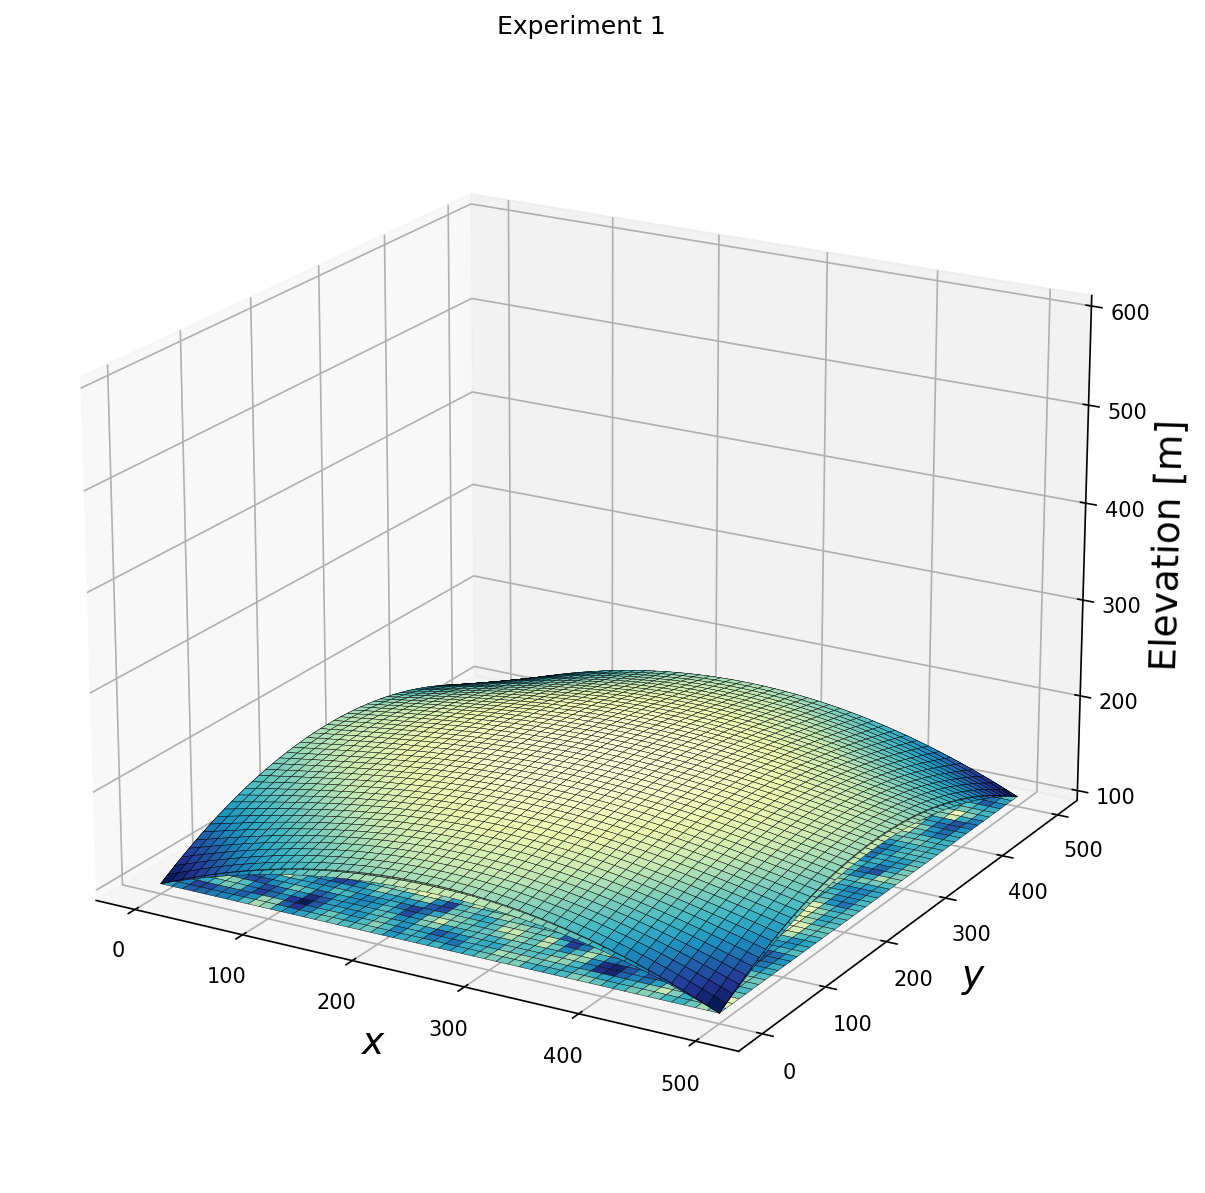

In [5]:
import matplotlib as mpl

h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1)
hnext = np.matrix(h0)

figcounter = 1

maxElev[0] = hnext.max()
for i in range(1,int(Nt)):
     
    hinit = hnext + U*dt
    
    hnext = hinit + alpha*Delta2*hinit     
    
    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i] 
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    
    maxElev[i] = hnext.max()
    
    
    
    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title('Elevation [m]', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='YlGnBu_r',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, hi+U*dt*Nt)
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1
        
ax.set_title("Experiment 1")
plt.show()


__Experiment 2__

In [6]:
import numpy as np
import matplotlib.pyplot as plt

hi = 100.0 # (m)
D = 2.5 * 1e-1  # (m^2/yr)  (reducing D by 1 order of magnitude)

ti = 0.0 # (yr)
tf = 100000.0 # (yr)
dt = 5 # (yr)

# Uplift rate (m/yr)
U = 0.005 # (m/yr)

# Plotting options
individual_plots = 0 # If 1, individual plot at every output interval, all stacked otherwise
OutputInterval = 20000.0 # (yr)

Nt = (tf - ti)/dt + 1

Noutput = (tf - ti)/OutputInterval + 1

xMax = yMax = 500.0
xMin = yMin = 0.0
Nx = Ny = 50

x = np.linspace(xMin,xMax,Nx)
y = np.linspace(yMin,yMax,Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

X, Y = np.meshgrid(x,y)

# Array to maximum elevation
maxElev2 = np.zeros(int(Nt))


## Compute the Stability Variable 

In [12]:
alpha = D*dt/dx**2
print("alpha = ",alpha)
print("dt = ",dt)
print("dx = ",dx)        

plt.show()

if alpha >= 0.5:
    raise Exception("Stability criteria error! Either decrease dt or increase dx!")

alpha =  0.012005000000000002
dt =  5
dx =  10.204081632653061


## Setup solver matrix


In [8]:
N = Nx*Ny

ind = np.linspace(0,N-1,N)
Ind = np.linspace(0,N-1,N).reshape((Ny,Nx))

Delta2 = np.matrix(np.diagflat(-4.0*np.ones((int(N),1)),k=0) + np.diagflat(np.ones((int(N-1),1)),k=1) \
    + np.diagflat(np.ones((int(N-1),1)),k=-1) + np.diagflat(np.ones((int(N-Nx),1)),k=int(Nx)) \
    + np.diagflat(np.ones((int(N-Ny),1)),k=-(int(Ny))))


## Setup the Boundary Conditions


In [9]:
NBound = np.array(Ind[0,:])
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])


Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))

H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))plt.title("Experiment 1")

#H_1D[:,0] = np.matrixplt.title("Experiment 1")(h0_1D)

H_1D[:,0] = np.matrix(h0_1D)


for i in range(1,int(Nt)):
    hinit_1D = H_1D[:,i-1] 
        
    hnext_1D = hinit_1D + alpha*Delta2_1D*hinit_1D + U*dt
    hnext_1D[0] = hi
    hnext_1D[-1] = hi

    H_1D[:,i] = hnext_1D[:,0]

## Run the modelplt.title("Experiment 1")

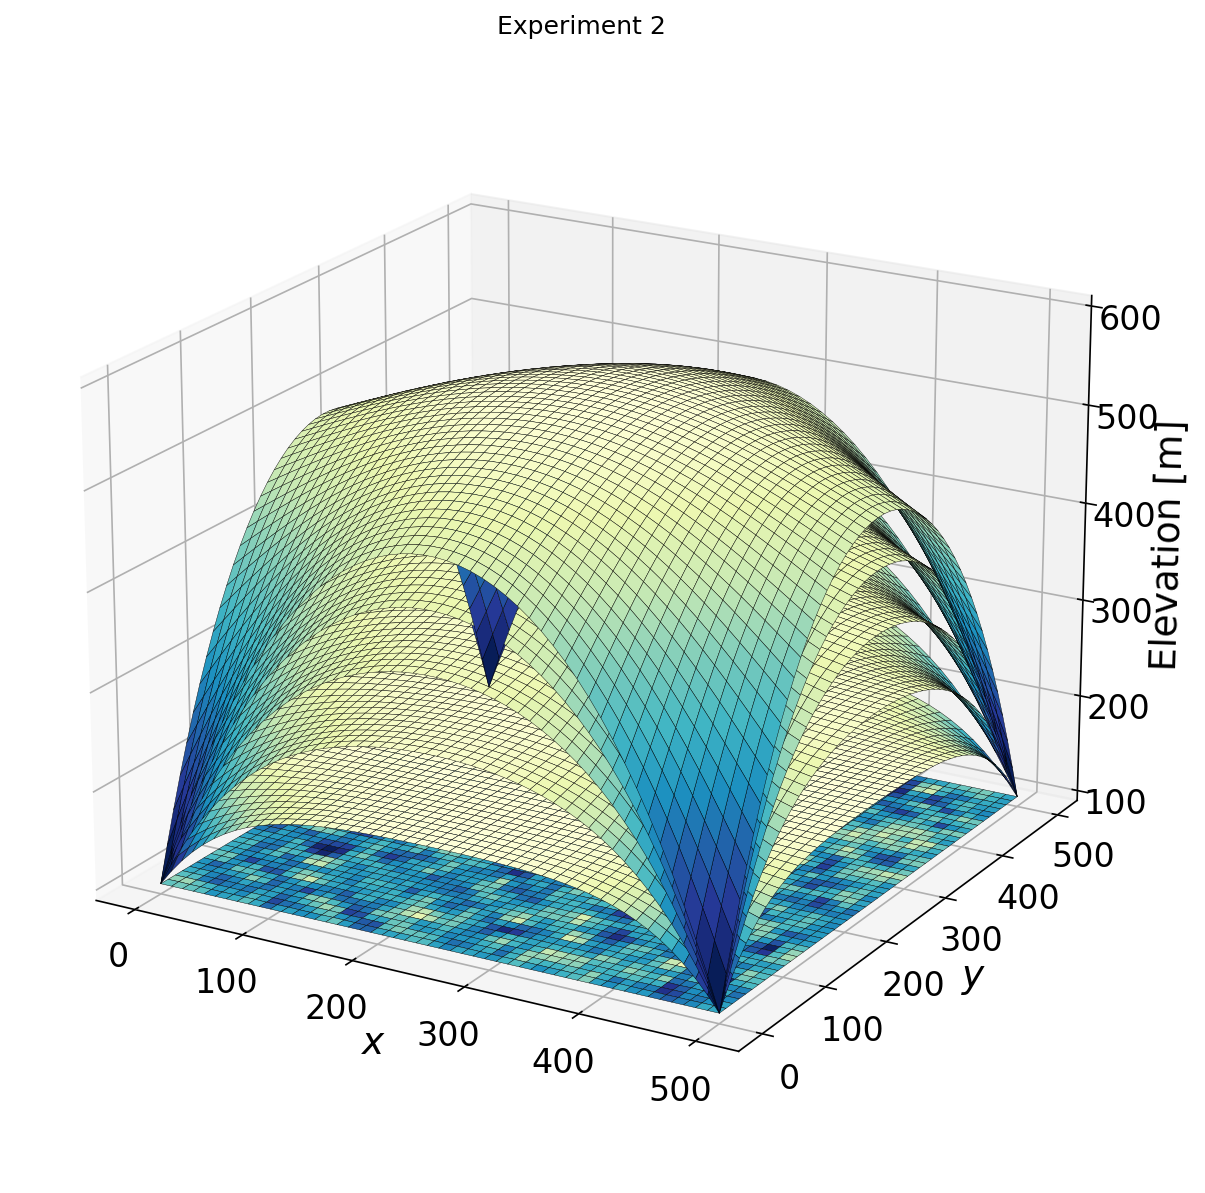

In [10]:
import matplotlib as mpl

h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1)
hnext = np.matrix(h0)

figcounter = 1

maxElev2[0] = hnext.max()

for i in range(1,int(Nt)):
        
    hinit = hnext + U*dt
    
    hnext = hinit + alpha*Delta2*hinit 

    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i] 
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    
    maxElev2[i] = hnext.max()
    
    
    
    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title('Elevation [m]', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='YlGnBu_r',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, hi+U*dt*Nt)
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1
        
ax.set_title("Experiment 2")
plt.show()


## Plot of maximum elevention against time

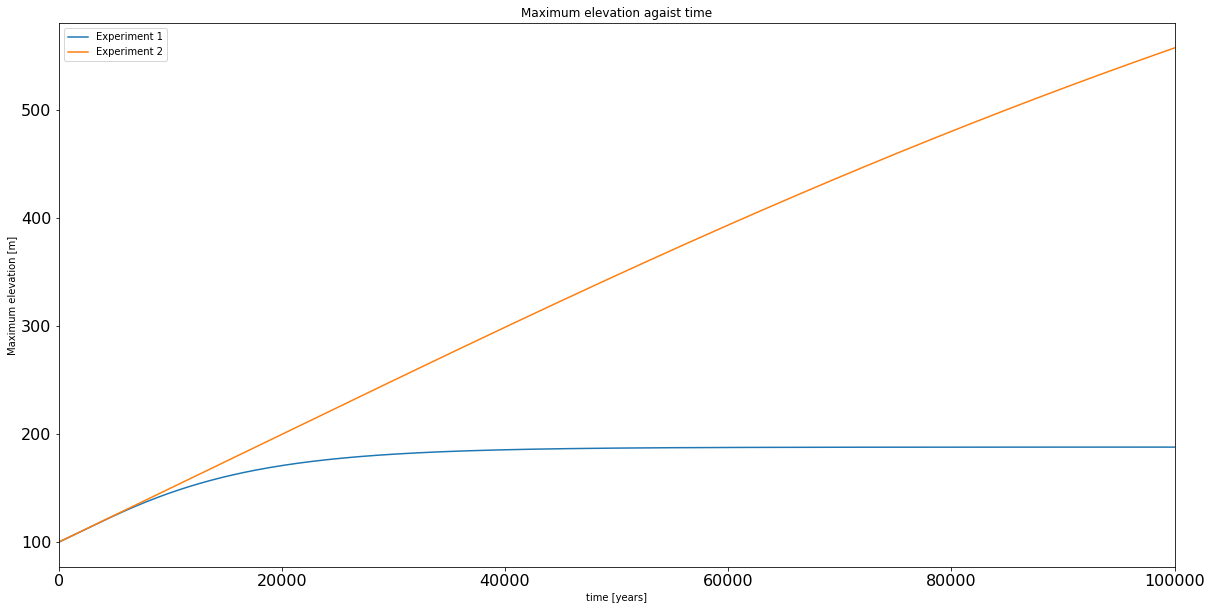

In [14]:

# profile in response to a lowering of head on 1-side of the domain
t = np.arange(ti,tf+dt,dt)

plt.rcParams["figure.figsize"] = (20,10)
plt.title("Maximum elevation agaist time")
plt.plot(t,maxElev, label = "Experiment 1")
plt.plot(t, maxElev2, label = "Experiment 2")
plt.legend()
plt.xlabel("time [years]")
plt.ylabel("Maximum elevation [m]")
plt.xlim([0,100000])
plt.show()

## Reflection questions

 __How does changing the diffusivity change the evolution of the maximum elevation in each experiment?__
 
 In the experiment 1 where the diffusivity is high, the maximum elevation grows slowly with time, and it reaches a steady state very fast, while for experiment 2 where the diffusivity  is low the maximum elevation grows fast  with time. Therefore, decreasing diffusivity increases the the rate of growth of maximum elevation with time.


__If we were to allow Experiments 1 and 2 to run for an infinite amount of time, how would the topographic surface between the experiments? What would be the only difference between the two topographies?__

At an infinite time, the topographies in both cases would look like curved sheets and the elevation of the sheets would stop increasing with time, the only difference would be the elevation of the topographies, with the topography in experimet 2 having a higher elevation.


### 